In [1]:
import numpy as np
import pandas as pd
import re
import gensim.downloader
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import text
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
import datetime
import nltk

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Data/tweet_emotions (1).csv')

In [3]:
data2 = data.copy()

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
pd.set_option('display.max_colwidth',None)
data.head(15)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


In [7]:
data['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [8]:
data['sentiment'].nunique()

13

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [10]:
data.isna().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [11]:
data.drop('tweet_id', axis=1, inplace=True)

In [12]:
def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation
    tweet = re.sub(r'\d+', '', tweet)  # Remove digits
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])  # Remove stopwords
    return tweet

In [13]:
data['content_clean'] = data['content'].apply(preprocess_tweet)

In [14]:
data.head()

,sentiment,content,content_clean
0,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin part
1,sadness,Layin n bed with a headache ughhhh...waitin on your call...,layin n bed headache ughhhhwaitin call
2,sadness,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,enthusiasm,wants to hang out with friends SOON!,wants hang friends soon
4,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",want trade someone houston tickets one


In [15]:
tweets = data["content_clean"]
labels = data["sentiment"]

In [16]:
encoder = OneHotEncoder(sparse_output=False)
labels_array = labels.to_numpy().reshape(-1, 1)
labels = encoder.fit_transform(labels_array)

In [17]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(tweets))
tokenized_texts = tokenizer.texts_to_sequences(tweets)
X = pad_sequences(tokenized_texts, maxlen=100)

In [18]:
glove_vect = gensim.downloader.load('glove-twitter-100')
embedding_dim = 100

In [19]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in glove_vect.key_to_index:
        embedding_matrix[i] = glove_vect[word]

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [21]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=100,
                    trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(encoder.categories_[0]), activation='softmax'))

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          3425100   
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [24]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Data/Model/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [25]:
model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
800/800 [==============================] - ETA: 0s - loss: 2.4775 - accuracy: 0.2812
Epoch 1: val_loss improved from inf to 2.11362, saving model to /content/drive/MyDrive/Data/Model/best_model.keras
800/800 [==============================] - 18s 14ms/step - loss: 2.4775 - accuracy: 0.2812 - val_loss: 2.1136 - val_accuracy: 0.3194
Epoch 2/20
796/800 [============================>.] - ETA: 0s - loss: 2.0454 - accuracy: 0.3210
Epoch 2: val_loss improved from 2.11362 to 2.06763, saving model to /content/drive/MyDrive/Data/Model/best_model.keras
800/800 [==============================] - 11s 14ms/step - loss: 2.0452 - accuracy: 0.3211 - val_loss: 2.0676 - val_accuracy: 0.3234
Epoch 3/20
796/800 [============================>.] - ETA: 0s - loss: 2.0136 - accuracy: 0.3260
Epoch 3: val_loss improved from 2.06763 to 2.04366, saving model to /content/drive/MyDrive/Data/Model/best_model.keras
800/800 [==============================] - 12s 15ms/step - loss: 2.0133 - accuracy: 0.3260 - 

In [26]:
model.load_weights('/content/drive/MyDrive/Data/Model/best_model.keras')

In [27]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

250/250 [==============================] - 1s 6ms/step - loss: 1.9824 - accuracy: 0.3366
Loss: 1.9823923110961914, Accuracy: 0.33662500977516174


In [28]:
def preprocess_input_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

In [29]:
def predict_sentiment(text, tokenizer, model, encoder):
    # Preprocess the input text
    preprocessed_text = preprocess_input_text(text)

    # Tokenize and pad the text
    tokenized_text = tokenizer.texts_to_sequences([preprocessed_text])
    padded_text = pad_sequences(tokenized_text, maxlen=100)

    # Predict sentiment
    prediction = model.predict(padded_text)
    predicted_label = encoder.inverse_transform(prediction)

    return predicted_label[0]

In [30]:
example_text = "Layin n bed with a headache ughhhh...waitin on your call...	"
predicted_sentiment = predict_sentiment(example_text, tokenizer, model, encoder)
print(f'Predicted Sentiment: {predicted_sentiment}')

1/1 [==============================] - 1s 685ms/step
Predicted Sentiment: ['worry']


In [31]:
sentiment_counts = data2['sentiment'].value_counts()

In [32]:
print(f"Number of 'worry' labels: {sentiment_counts.get('worry', 0)}")

Number of 'worry' labels: 8459


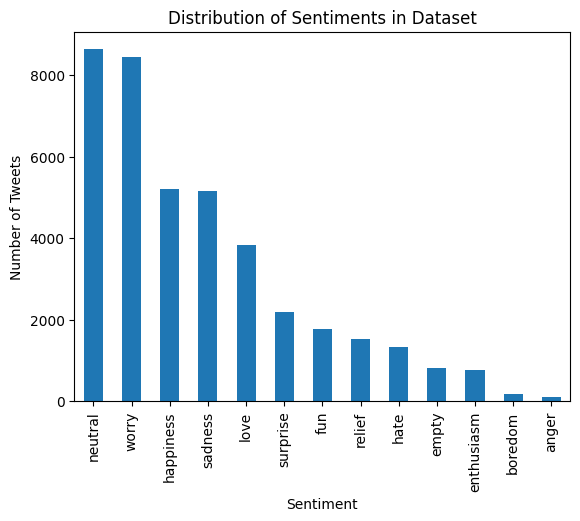

In [33]:
import matplotlib.pyplot as plt

# Plot the sentiment distribution
sentiment_counts.plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Sentiments in Dataset')
plt.show()


In [34]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_array), y=labels_array.flatten())
class_weights_dict = dict(enumerate(class_weights))

# Update model training with class weights
model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
800/800 [==============================] - ETA: 0s - loss: 2.5842 - accuracy: 0.2777
Epoch 1: val_loss did not improve from 1.98244
800/800 [==============================] - 15s 14ms/step - loss: 2.5842 - accuracy: 0.2777 - val_loss: 2.3401 - val_accuracy: 0.2903
Epoch 2/20
800/800 [==============================] - ETA: 0s - loss: 2.4713 - accuracy: 0.2517
Epoch 2: val_loss did not improve from 1.98244
800/800 [==============================] - 11s 14ms/step - loss: 2.4713 - accuracy: 0.2517 - val_loss: 2.3265 - val_accuracy: 0.2969
Epoch 3/20
403/800 [==============>...............] - ETA: 4s - loss: 2.4912 - accuracy: 0.2344

KeyboardInterrupt: 